## Catalog Matching - finding UDGs in DES data

In [171]:
# Import stuff
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
import skymapper as skm
from code.plot_utils import plot_pretty

%matplotlib inline
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


#### Import the DES catalogue

Import the DES data. We have a region of $+/- 3^o$ around the Fornax galaxy cluster (coordinates $RA = 54.61625, \,\, DEC = -35.448333$). So the region selected is:

\begin{equation}
51.61625 < RA < 58.61625\\
-38.44833 < DEC < - 32.44833
\end{equation}

In [172]:
#Now the data

DES = fits.open('DES_FORNAX.fits')
print DES[1].header.keys

<bound method Header.keys of XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  102 / length of dimension 1                          
NAXIS2  =              2618516 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   24 / number of table fields                         
TTYPE1  = 'coadd_object_id'                                                     
TFORM1  = 'K       '                                                            
TTYPE2  = 'ra      '                                                            
TFORM2  = 'D       '                                                            

In [173]:
# RA and DEC of every object
RA = DES[1].data['ra']
DEC = DES[1].data['dec']

#### Some preliminary cuts

Let's make some very basic/ preliminary cuts.

First I will apply:

\begin{equation}
flags\_gold = 0
\end{equation}
(be sure that object is part of the gold catalogue)

and

\begin{equation}
spread\_model\_i + (5/3)spreaderr\_model\_i > 0.007
\end{equation}

For star- galaxy separation (keep only galaxies)

In [174]:
spread_model_i = DES[1].data['spread_model_i']
speraderr_model_i = DES[1].data['spreaderr_model_i']
Flags_gold = DES[1].data['flags_gold']

RA = RA[(Flags_gold==0.0)&((spread_model_i+(5.0/3.0)*speraderr_model_i)>0.007)]
DEC = DEC[(Flags_gold==0.0)&((spread_model_i+(5.0/3.0)*speraderr_model_i)>0.007)]

Let's plot the angular distribution and projected density of all objects in des Y3 in that patch.

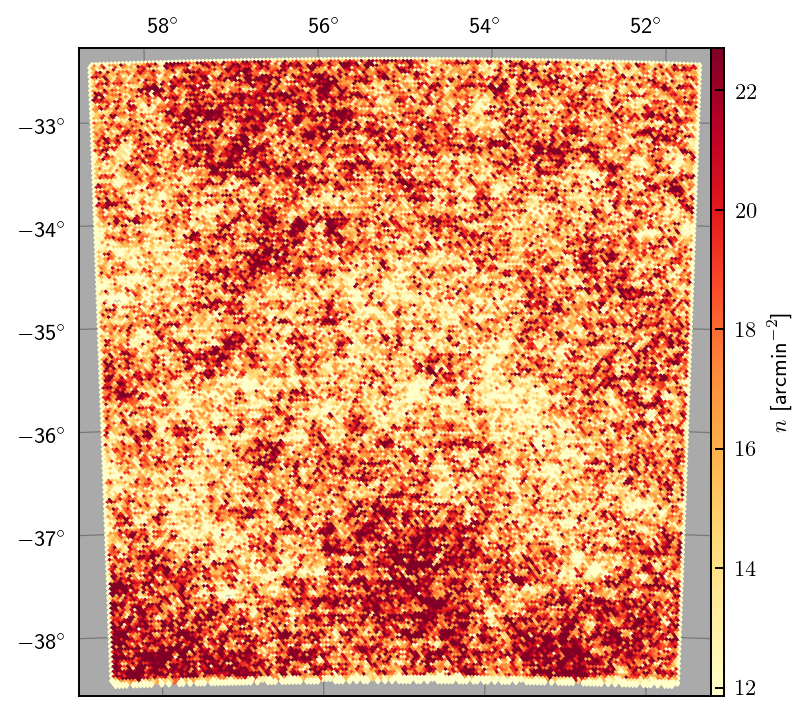

In [175]:
# plot density in healpix cells
nside = 2*16*64
sep = 2*16*50


plot_pretty()
fig, ax, proj = skm.plotDensity(RA, DEC, nside=nside, sep=sep)
sep = 1
meridians = np.arange(-90, 90+sep, sep)
parallels = np.arange(0, 360+2*sep, 2*sep)
skm.setMeridianPatches(ax, proj, meridians, linestyle='-', lw=0.5, alpha=0.3, zorder=2)
skm.setParallelPatches(ax, proj, parallels, linestyle='-', lw=0.5, alpha=0.3, zorder=2)
skm.setMeridianLabels(ax, proj, meridians, loc="left", fmt=skm.pmDegFormatter)
skm.setParallelLabels(ax, proj, parallels, loc="bottom") 

### Now import the data from Muñoz et al

In the munoz et al catalogue the coordinates of the UDGs around Fornax are given in the following format (different columns for each):

RAh $\to$ Hour of Right Ascention (h)

RAm $\to$ Minute of Right Ascention (m)

RAs $\to$ Second of Right Ascention (s)

DE- $\to$ Sign of the Declination (negative in all cases)

DEd $\to$ Degree of Declination ($^o$)

DEm $\to$ Minute (arc) of Declination ($'$)

DEs $\to$ Second (arc) of Declination ($''$)

Note that the minutes and seconds of Right ascention are $\mathbf{not}$ the same as the minutes and seconds of declination (minutes and seconds of arc).

In [176]:
RAh, RAm, RAs, DEd, DEm, DEs =  loadtxt("table1.dat",  unpack=3, usecols=[1,2,3,4,5,6])

Although AstroPy, trough the "coordinates" package, has the ability to easily convert between different astronomical coordinate systems, here I will manually convert the RA and DEC of the Muñoz objects to degrees (from h,m,s and d,m,s accordingly). I do this since each of the components is given as a different column; so I think it is easier to convert them manually than trying to convert them to a string etc...

The conversion is:

For DEC:

DEC (degrees) = DEd + DEm/60 + DEs/3600

RA (degrees) = RAh$ \times 15$ + RAm/4 + RAs/240

See wiki or SDSS site for the explanation why the conversion to degrees is different for DEC and for RA.


In [177]:
RA_f = RAh*15.0 + RAm/4.0 + RAs/240.0  # Right ascension in degrees for the Muñoz et. al. objects aroud Fornax

DEC_f = - (abs(DEd) + DEm/60.0 + DEs/3600.0) 

Let's see their distribution

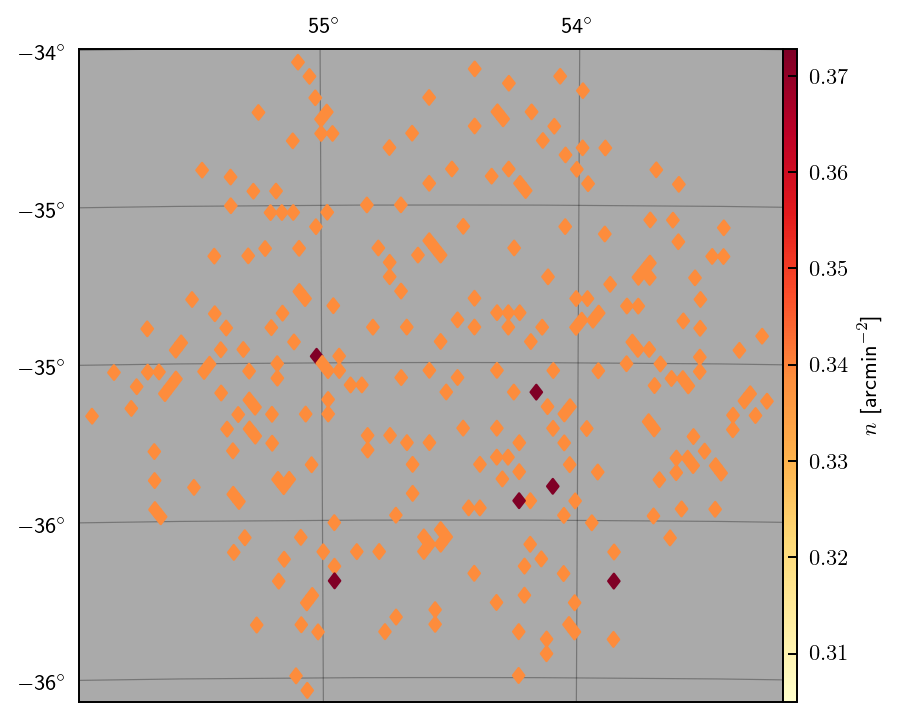

In [178]:
# plot density in healpix cells
nside = 2*16*64
sep = 2*16*50


plot_pretty()
fig, ax, proj = skm.plotDensity(RA_f, DEC_f, nside=nside, sep=sep)
sep = 0.5
meridians = np.arange(-90, 90+sep, sep)
parallels = np.arange(0, 360+2*sep, 2*sep)
skm.setMeridianPatches(ax, proj, meridians, linestyle='-', lw=0.5, alpha=0.3, zorder=2)
skm.setParallelPatches(ax, proj, parallels, linestyle='-', lw=0.5, alpha=0.3, zorder=2)
skm.setMeridianLabels(ax, proj, meridians, loc="left", fmt=skm.pmDegFormatter)
skm.setParallelLabels(ax, proj, parallels, loc="bottom") 

As we can see, they occupy a much smaller space in $RA, DEC$ than the $\pm$ three degrees region around  the Fornax cluster we downloaded from DES data.

The total number of objects is:

In [179]:
print(np.size(RA_f))

284


### Matching the catalogs 

In [180]:
from astropy import units as u
from astropy.coordinates import SkyCoord


coo_DES = SkyCoord(RA*u.deg, DEC*u.deg, frame='icrs') #Coordinates of objects (all) in the DES data
coo_Mun = SkyCoord(RA_f*u.deg, DEC_f*u.deg, frame='icrs')  #Coordinates of objects (all) in the Muñoz et al data 

Now we are matching the the Muñoz et. al. catalog to the DES catalog. The order matters; there many more entries in the DES catalog, so it is likely that most Muñoz et. al. objects are in DES but not vice versa. 

In [181]:
idx_DES, d2d_DES, d3D_DES = coo_Mun.match_to_catalog_sky(coo_DES)

Now we have the matching.

idx_DES $\to$  indices that show the closest matches in the DES arrays 

d2d_DES $\to$ on-sky (angular) distance between the matches

d3d_DES $\to$ real space distance between the matches. Can be disregarded since we didn't give a line-of-sight distance.

Let's get the RAs and DECs of the matched objects and then make a scatter plot of them and the Muñoz et. al. objects

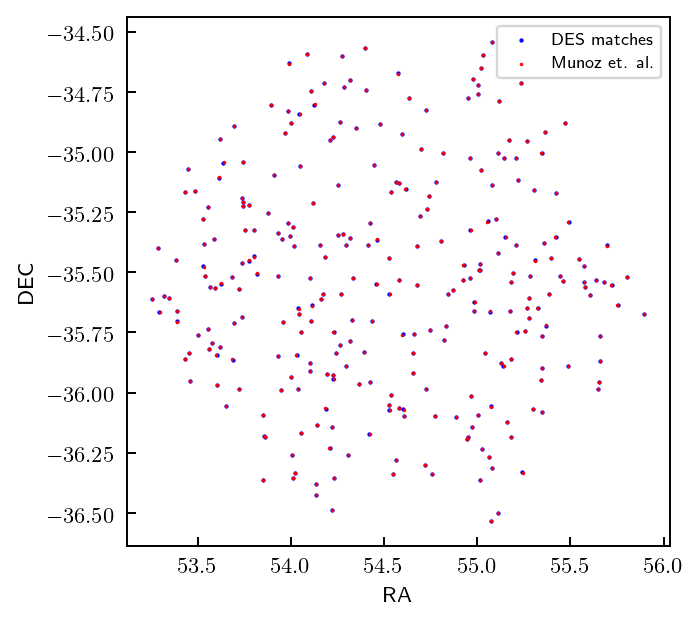

In [182]:
RA_match = RA[idx_DES]
DEC_match = DEC[idx_DES]

plot_pretty()

fig = plt.figure(figsize=(4,4))

plt.scatter(RA_match, DEC_match, c='b', s=0.6,  label='DES matches')
plt.scatter(RA_f, DEC_f, c='r', s=0.2, label='Munoz et. al.')

plt.xlabel('RA'); plt.ylabel('DEC')

#plt.xlim(53,56.5)

plt.legend(frameon=True, loc='upper right', fontsize=7)

plt.show()

Nice! It seems that we have a good matching! At least visually the mathced objects seem to coincide with the Muñoz et. al. objects (UDGs). Let's hope that there is no contamination, from stars for example etc. 

Let's plot a histogram of the angular (2d) separations of the matched objects.

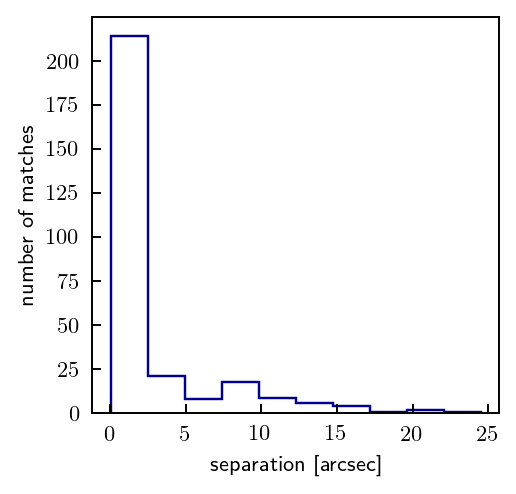

In [183]:
plot_pretty()
fig = plt.figure(figsize=(3,3))

plt.hist(d2d_DES.arcsec, histtype='step', color='darkblue')
plt.xlabel('separation [arcsec]'); plt.ylabel('number of matches')
plt.show()

So, most of them  have angular separations $<5$ arcsecons, with just a few being separated with more than 10 arcsecs.

As a further check, let's do something similar to that done in the example presented in the AstroPy tutorial.

Here is the rationale:

Our matches are separated by an angular distance of a few arcseconds. Most of them are $< 5$ arcseconds; this is a good indication that we have actal matches (they are the same objects).

But are we sure it's not just that anything has matches within a few arcseconds? We will compare this with a set of random points.

We first create a set of uniformly random points (with size matching coo_Mun) that cover the same range of RA/Decs that are in coo_DES. 

In [184]:
ras_sim = np.random.rand(len(coo_Mun))*coo_DES.ra.ptp() + coo_DES.ra.min()
decs_sim = np.random.rand(len(coo_Mun))*coo_DES.dec.ptp() + coo_DES.dec.min()

Now we create a SkyCoord object from these  simulated points and match it to coo_DES just like we did above for coo_Mun.

In [185]:
coo_simulated = SkyCoord(ras_sim, decs_sim)  
idx_sim, d2d_sim, d3d_sim = coo_simulated.match_to_catalog_sky(coo_DES)

Now lets plot up the histogram of separations from our simulated catalog so we can compare to the above results from the real catalog.

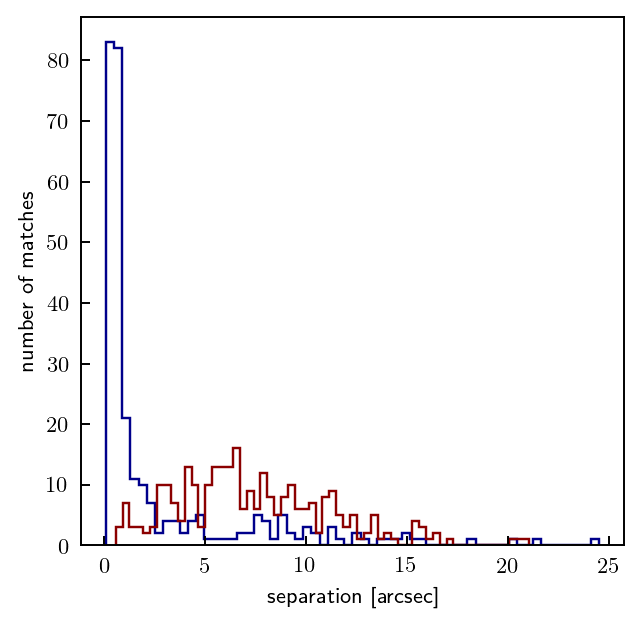

In [188]:
plot_pretty()
fig = plt.figure(figsize=(4,4))

plt.hist(d2d_DES.arcsec, histtype='step', bins=60,color='darkblue')
plt.hist(d2d_sim.arcsec, histtype='step', bins=60, color='darkred')
plt.xlabel('separation [arcsec]'); plt.ylabel('number of matches')
plt.show()

#### OOOps! 
It seems that  by using randomly placed objects we still found matches withing a few arcseconds. 

I will keep only those with separation < 2 arcsecs that have higher chance to be real matches (This is quite arbitrary, just a first guess).


In [196]:
idx_DES_new = idx_DES[(d2d_DES.arcsec<2.0)]

In [197]:
RA_match = RA[idx_DES_new]
DEC_match = DEC[idx_DES_new]

print(np.size(RA_match))

204


So, limiting the matches to those with separation $<2.0$ arcsec, we recover 204 objects (out of  284).  

### Now it is time for exploration and fun!!!

First, let's plot the matched objects in the space of magnitude vs angular size (MAG_AUTO vs FLUX_RADIUS) for the three filters (G,R,I)

In [201]:
#First import the columns

MAG_AUTO_G = DES[1].data['mag_auto_g']
MAG_AUTO_R = DES[1].data['mag_auto_r']
MAG_AUTO_I = DES[1].data['mag_auto_i']

FLUX_RADIUS_G = DES[1].data['flux_radius_g']
FLUX_RADIUS_R = DES[1].data['flux_radius_r']
FLUX_RADIUS_I = DES[1].data['flux_radius_i'] 



#Make the preliminary cuts

MAG_AUTO_G = MAG_AUTO_G[(Flags_gold==0.0)&((spread_model_i+(5.0/3.0)*speraderr_model_i)>0.007)]
MAG_AUTO_R = MAG_AUTO_R[(Flags_gold==0.0)&((spread_model_i+(5.0/3.0)*speraderr_model_i)>0.007)]
MAG_AUTO_I = MAG_AUTO_I[(Flags_gold==0.0)&((spread_model_i+(5.0/3.0)*speraderr_model_i)>0.007)]

FLUX_RADIUS_G = FLUX_RADIUS_G[(Flags_gold==0.0)&((spread_model_i+(5.0/3.0)*speraderr_model_i)>0.007)]
FLUX_RADIUS_R = FLUX_RADIUS_R[(Flags_gold==0.0)&((spread_model_i+(5.0/3.0)*speraderr_model_i)>0.007)]
FLUX_RADIUS_I = FLUX_RADIUS_I[(Flags_gold==0.0)&((spread_model_i+(5.0/3.0)*speraderr_model_i)>0.007)]

In [230]:
#Select the matched objects

mag_g_match = MAG_AUTO_G[idx_DES_new]
mag_r_match = MAG_AUTO_R[idx_DES_new]
mag_i_match = MAG_AUTO_I[idx_DES_new]

flux_g_match = FLUX_RADIUS_G[idx_DES_new]
flux_r_match = FLUX_RADIUS_R[idx_DES_new]
flux_i_match = FLUX_RADIUS_I[idx_DES_new]

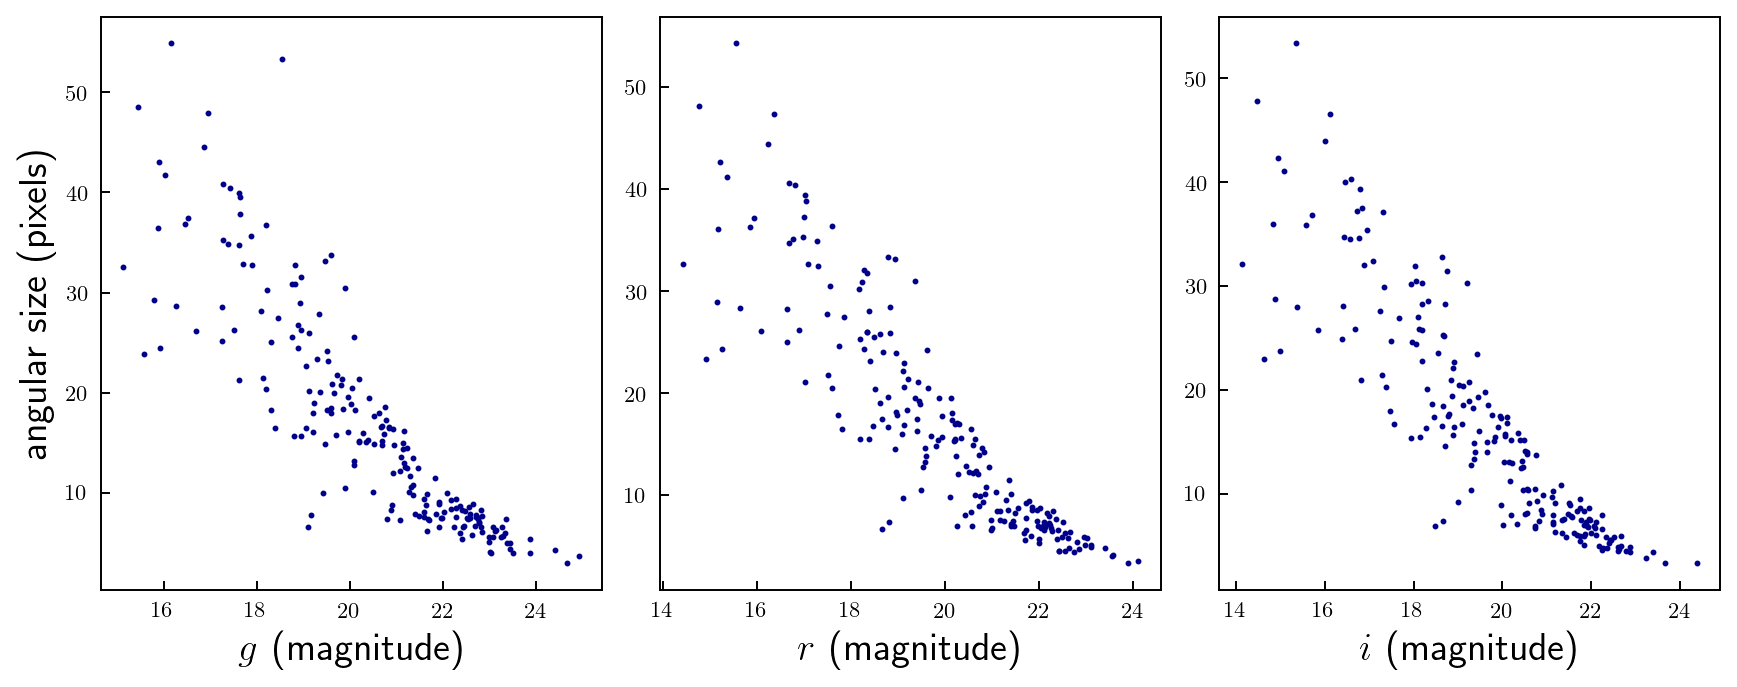

In [234]:
#Plots

fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (10.0,4.0))

ax[0].scatter(mag_g_match, flux_g_match, color='darkblue', s=2.0)
ax[0].set_xlabel(r'$g$ (magnitude)',fontsize=16);ax[0].set_ylabel('angular size (pixels)', fontsize=16)

ax[1].scatter(mag_r_match, flux_r_match, color='darkblue', s=2.0)
ax[1].set_xlabel(r'$r$ (magnitude)',fontsize=16);

ax[2].scatter(mag_i_match, flux_i_match,  color='darkblue', s=2.0)
ax[2].set_xlabel(r'$i$ (magnitude)',fontsize=16);

plt.tight_layout()
plt.show()

Nice!

Now, the Muñoz et al catalog does not provide all this info to make comparisons. But it does provide $i$ magnitudes and effective radii (in arcsecs). We can make a plot of these two quantities and visually compare them with the similar plot for the matched quantities (above).

In [235]:
i_mag, Eff_rad = loadtxt("table3.dat",  unpack=3, usecols=[7,10])

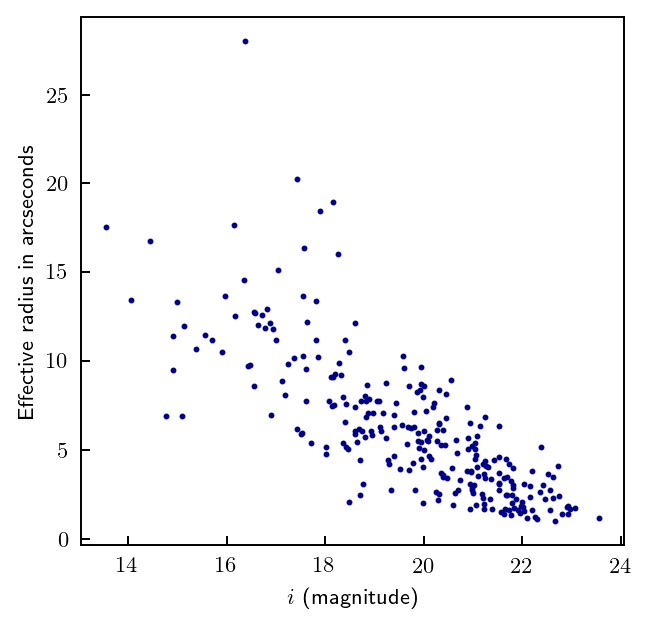

In [236]:
fig = plt.figure(figsize=(4,4))

plt.scatter(i_mag, Eff_rad,  color='darkblue', s=2.0)
plt.xlabel('$i$ (magnitude)'); plt.ylabel('Effective radius in arcseconds')
plt.show()

Visually they look pretty similar (although for one to one comparison one has to conver effective radius in arcsec to this flux radius in pixels (or the opposite).

Anyway, can we be sure that the visual similarity isn't just by chance? In other words that any selection of objects will give a similar pattern in mag_i - radius space?

Let's go back to our simulated random points, and make a similar plot of the mathed objects to these random objects.

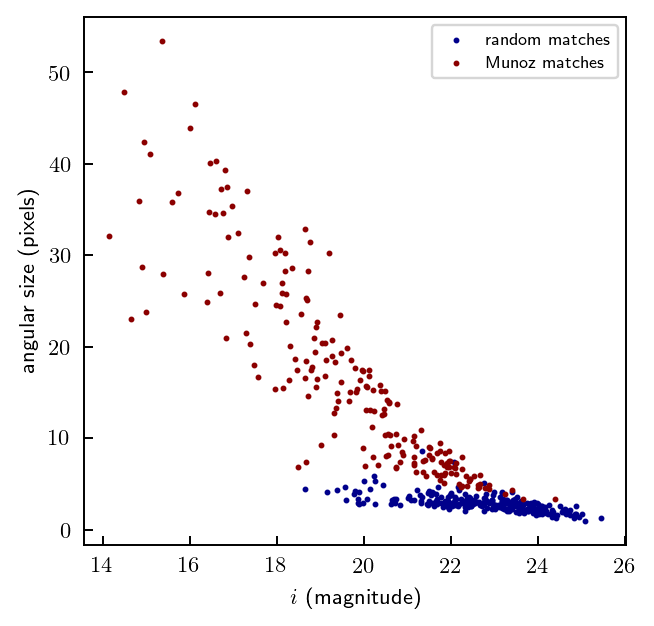

In [241]:
mag_i_sim = MAG_AUTO_I[idx_sim]
flux_rad_sim = FLUX_RADIUS_I[idx_sim]

fig = plt.figure(figsize=(4,4))

plt.scatter(mag_i_sim, flux_rad_sim,  color='darkblue', s=2.0, label='random matches')
plt.scatter(mag_i_match, flux_i_match,  color='darkred', s=2.0, label='Munoz matches')
plt.xlabel('$i$ (magnitude)'); plt.ylabel('angular size (pixels)')


plt.legend(frameon=True, loc='upper right', fontsize=7)
plt.show()

That's promising! It seems that there is a difference between randomly selected points (matches to random points) and the matches to the Muñoz et al. catalog. Especially UDG matches have on average smaller magnitudes (is that good though? - i would expect them to be fainter) and larger angular sizes (this is expected I think).